# **Library**

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import os
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import cv2
import time
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch import optim
from PIL import Image
from timm import create_model
from sklearn.model_selection import KFold
import json
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from timm.layers import Conv2dSame
import pandas as pd
import re
from transformers import BertTokenizer

seed = 42  
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.empty_cache()


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## **Variable**

In [2]:
class_index = {'benign': 0, 'malignant': 1}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size_1 = 8
epochs = 100
train_losses_fold1 = []
train_losses_fold2 = []
train_losses_fold3 = []
train_losses_fold4 = []
train_losses_fold5 = []
valid_accuracy_scores_fold1 = []
valid_accuracy_scores_fold2 = []
valid_accuracy_scores_fold3 = []
valid_accuracy_scores_fold4 = []
valid_accuracy_scores_fold5 = []
best_val_acc = 0
Model_Path_Folds = [
    'Best_Epoch_Accuracy_Fold1',
    'Best_Epoch_Accuracy_Fold2',
    'Best_Epoch_Accuracy_Fold3',
    'Best_Epoch_Accuracy_Fold4',
    'Best_Epoch_Accuracy_Fold5'
]
k_folds = 5
random_state = 42
kf = KFold(n_splits=k_folds, shuffle = True, random_state = random_state)
splits = {}
save = 0
total_val_accuracy = 0
total_val_precision = 0
total_val_recall = 0
total_val_specificity = 0
total_val_f1 = 0
total_val_mcc = 0

## **Assistive functions-1**

In [3]:
def freeze_stages(model, stage_indices):
    for idx in stage_indices:
        for param in model.stages[idx].parameters():
            param.requires_grad = False
        print(f"Stage {idx} frozen.")

In [4]:
maxvits_model1 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
maxvits_model1.head.fc = nn.Linear(maxvits_model1.head.in_features, 512).to(device)
# freeze_stages(maxvits_model1, stage_indices=[1])

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

# **Image Model 1 (Ultrasound)**

In [5]:
class Image_model1(nn.Module):
    def __init__(self):
        super(Image_model1,self).__init__()
        self.model = maxvits_model1
        
    def forward(self,input1):
        output = self.model(input1)
        return output

In [6]:
Imgmodel1 = Image_model1()
Imgmodel1 = Imgmodel1.to('cuda')
summary(Imgmodel1,(2,3,224,224))

Layer (type:depth-idx)                                            Output Shape              Param #
Image_model1                                                      [2, 512]                  --
├─MaxxVit: 1-1                                                    [2, 512]                  --
│    └─Stem: 2-1                                                  [2, 64, 112, 112]         --
│    │    └─Conv2dSame: 3-1                                       [2, 64, 112, 112]         1,792
│    │    └─BatchNormAct2d: 3-2                                   [2, 64, 112, 112]         128
│    │    └─Conv2d: 3-3                                           [2, 64, 112, 112]         36,928
│    └─Sequential: 2-2                                            [2, 768, 7, 7]            --
│    │    └─MaxxVitStage: 3-4                                     [2, 96, 56, 56]           638,972
│    │    └─MaxxVitStage: 3-5                                     [2, 192, 28, 28]          2,488,248
│    │    └─MaxxVitStage:

## **Assistive functions-2**

In [7]:
maxvits_model2 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
maxvits_model2.stem.conv1 = Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2))
maxvits_model2.head.fc = nn.Linear(maxvits_model2.head.in_features, 512).to(device)
# freeze_stages(maxvits_model2, stage_indices=[1])
# maxvits_model3 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
# maxvits_model3.head.fc = nn.Linear(maxvits_model3.head.in_features, 512).to(device)


# **Image Model 2 (Mammogram)**

In [8]:
class Image_model21(nn.Module):
    def __init__(self):
        super(Image_model21,self).__init__()
        self.model = maxvits_model2
        
    def forward(self,input1):
        output = self.model(input1)
        return output

In [9]:
Imgmodel21 = Image_model21()
Imgmodel21 = Imgmodel21.to('cuda')
summary(Imgmodel21,(2,3,224,224))

Layer (type:depth-idx)                                            Output Shape              Param #
Image_model21                                                     [2, 512]                  --
├─MaxxVit: 1-1                                                    [2, 512]                  --
│    └─Stem: 2-1                                                  [2, 64, 112, 112]         --
│    │    └─Conv2dSame: 3-1                                       [2, 64, 112, 112]         1,792
│    │    └─BatchNormAct2d: 3-2                                   [2, 64, 112, 112]         128
│    │    └─Conv2d: 3-3                                           [2, 64, 112, 112]         36,928
│    └─Sequential: 2-2                                            [2, 768, 7, 7]            --
│    │    └─MaxxVitStage: 3-4                                     [2, 96, 56, 56]           638,972
│    │    └─MaxxVitStage: 3-5                                     [2, 192, 28, 28]          2,488,248
│    │    └─MaxxVitStage:

In [10]:
# class Image_model22(nn.Module):
#     def __init__(self):
#         super(Image_model22,self).__init__()
#         self.model = maxvits_model3
        
#     def forward(self,input1):
#         output = self.model(input1)
#         return output

In [11]:
# Imgmodel22 = Image_model22()
# Imgmodel22 = Imgmodel22.to('cuda')
# summary(Imgmodel22,(2,3,224,224))

## **Assistive functions-3**

In [12]:
maxvits_model4 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
maxvits_model4.stem.conv1 = Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2))
maxvits_model4.head.fc = nn.Linear(maxvits_model4.head.in_features, 512).to(device)
# freeze_stages(maxvits_model4, stage_indices=[1])
# maxvits_model5 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
# maxvits_model5.head.fc = nn.Linear(maxvits_model5.head.in_features, 512).to(device)
# maxvits_model6 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
# maxvits_model6.head.fc = nn.Linear(maxvits_model6.head.in_features, 512).to(device)
# maxvits_model7 = create_model('maxvit_small_tf_224.in1k', pretrained=True)
# maxvits_model7.head.fc = nn.Linear(maxvits_model6.head.in_features, 512).to(device)

# **Image Model 3 (Microscopic)**

In [13]:
class Image_model31(nn.Module):
    def __init__(self):
        super(Image_model31,self).__init__()
        self.model = maxvits_model4
        
    def forward(self,input1):
        output = self.model(input1)
        return output

In [14]:
Imgmodel31 = Image_model31()
Imgmodel31 = Imgmodel31.to('cuda')
summary(Imgmodel31,(2,3,224,224))

Layer (type:depth-idx)                                            Output Shape              Param #
Image_model31                                                     [2, 512]                  --
├─MaxxVit: 1-1                                                    [2, 512]                  --
│    └─Stem: 2-1                                                  [2, 64, 112, 112]         --
│    │    └─Conv2dSame: 3-1                                       [2, 64, 112, 112]         1,792
│    │    └─BatchNormAct2d: 3-2                                   [2, 64, 112, 112]         128
│    │    └─Conv2d: 3-3                                           [2, 64, 112, 112]         36,928
│    └─Sequential: 2-2                                            [2, 768, 7, 7]            --
│    │    └─MaxxVitStage: 3-4                                     [2, 96, 56, 56]           638,972
│    │    └─MaxxVitStage: 3-5                                     [2, 192, 28, 28]          2,488,248
│    │    └─MaxxVitStage:

In [15]:
# class Image_model32(nn.Module):
#     def __init__(self):
#         super(Image_model32,self).__init__()
#         self.model = maxvits_model5
        
#     def forward(self,input1):
#         output = self.model(input1)
#         return output

In [16]:
# Imgmodel32 = Image_model32()
# Imgmodel32 = Imgmodel32.to('cuda')
# summary(Imgmodel32,(2,3,224,224))

In [17]:
# class Image_model33(nn.Module):
#     def __init__(self):
#         super(Image_model33,self).__init__()
#         self.model = maxvits_model6
        
#     def forward(self,input1):
#         output = self.model(input1)
#         return output

In [18]:
# Imgmodel33 = Image_model33()
# Imgmodel33 = Imgmodel33.to('cuda')
# summary(Imgmodel33,(2,3,224,224))

In [19]:
# class Image_model34(nn.Module):
#     def __init__(self):
#         super(Image_model34,self).__init__()
#         self.model = maxvits_model7
        
#     def forward(self,input1):
#         output = self.model(input1)
#         return output

In [20]:
# Imgmodel34 = Image_model34()
# Imgmodel34 = Imgmodel34.to('cuda')
# summary(Imgmodel34,(2,3,224,224))

## **Assistive functions - small language model**

In [21]:
print(None)

None


# **Small language Model 1**

In [22]:
class MiniBERTEncoder(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=512, num_heads=16, hidden_dim=256, num_layers=32):
        super(MiniBERTEncoder, self).__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(768, embed_dim) 
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pooler = nn.Linear(embed_dim, embed_dim)
        #self.classifier = nn.Linear(embed_dim, 2)  
        
    def forward(self, input_ids):
        seq_length = input_ids.shape[1]
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0)
        
        token_embeddings = self.token_embedding(input_ids)
        position_embeddings = self.position_embedding(positions)
        
        embeddings = token_embeddings + position_embeddings
        encoded_output = self.transformer(embeddings)
        pooled_output = self.pooler(encoded_output[:, 0,:]) 
        pooled_output = torch.tanh(pooled_output)
        
        #output = self.classifier(pooled_output)  
        
        # return output, pooled_output
        return pooled_output


In [23]:
from torchinfo import summary
dummy_model = MiniBERTEncoder()
dummy_input = torch.randint(0, 30522, (8, 128)) 
summary(dummy_model, input_data=dummy_input)


Layer (type:depth-idx)                             Output Shape              Param #
MiniBERTEncoder                                    [8, 512]                  --
├─Embedding: 1-1                                   [8, 128, 512]             15,627,264
├─Embedding: 1-2                                   [1, 128, 512]             393,216
├─TransformerEncoder: 1-3                          [8, 128, 512]             --
│    └─ModuleList: 2-1                             --                        --
│    │    └─TransformerEncoderLayer: 3-1           [8, 128, 512]             1,315,584
│    │    └─TransformerEncoderLayer: 3-2           [8, 128, 512]             1,315,584
│    │    └─TransformerEncoderLayer: 3-3           [8, 128, 512]             1,315,584
│    │    └─TransformerEncoderLayer: 3-4           [8, 128, 512]             1,315,584
│    │    └─TransformerEncoderLayer: 3-5           [8, 128, 512]             1,315,584
│    │    └─TransformerEncoderLayer: 3-6           [8, 128, 512]   

In [24]:
slm_model = MiniBERTEncoder()
slm_model = slm_model.to(device)

## **Assistive functions - Large language model**

In [25]:
print(None)

None


# **Large language Model 1**

In [26]:
print(None)

None


## **Assistive functions of main model**

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvFusionClassifier(nn.Module):
    def __init__(self, 
                 hidden_dim=512, 
                 num_classes=2):
        super(ConvFusionClassifier, self).__init__()
        self.fusion_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )  
        
    def forward(self, feat_a, feat_b):
        fused = torch.cat([feat_a, feat_b], dim=-1)
        out = self.fusion_mlp(fused)
        return out


# **Main Model**

In [28]:
class v_model(nn.Module):
    def __init__(self):
        super(v_model,self).__init__()
        out_features = 512
        num_classes = 2
        modality_dropout_prob = 0.5
        self.encoder_ultrasound       = Image_model1()
        #self.encoder_mammogram1       = Image_model21()
        # self.encoder_mammogram2       = Image_model22()
        # self.encoder_microscopic1     = Image_model31()
        # self.encoder_microscopic2     = Image_model32()
        # self.encoder_microscopic3     = Image_model33()
        # self.encoder_microscopic4     = Image_model34()
        # self.placeholder_ultrasound   = torch.zeros(num_classes).to(device)
        # self.placeholder_mammogram1   = torch.zeros(num_classes).to(device)
        # # self.placeholder_mammogram2   = nn.Parameter(torch.zeros(out_features))
        # self.placeholder_microscopic1 = torch.zeros(num_classes).to(device)
        # self.placeholder_microscopic2 = nn.Parameter(torch.zeros(out_features))
        # self.placeholder_microscopic3 = nn.Parameter(torch.zeros(out_features))
        # self.placeholder_microscopic4 = nn.Parameter(torch.zeros(out_features))
        
        # self.fusion = nn.Sequential(
        #     nn.Linear(num_classes * 3, num_classes),
        # )
        #self.classifier1 = nn.Linear(out_features, num_classes)
        #self.classifier2 = nn.Linear(out_features, num_classes)
        #self.classifier3 = nn.Linear(out_features, num_classes)
        #self.modality_dropout_prob = modality_dropout_prob
    def forward(self, ultrasound=None, mammogram1=None, mammogram2=None, microscopic1=None, microscopic2=None, microscopic3=None, microscopic4=None, training=True):
        batch_size = None
        # if mammogram1 is not None:
        #     if mammogram2 is not None:
        #         mammogram1 = torch.cat([mammogram1,mammogram2], dim=1)
        # if microscopic1 is not None:
        #     if microscopic2 is not None:
        #         if microscopic3 is not None:
        #             if microscopic4 is not None:
        #                 microscopic1 = torch.cat([microscopic1,microscopic2,microscopic3,microscopic4],dim=1)
        
        # for modality in [ultrasound, mammogram1, microscopic1]:
        #     if modality is not None:
        #         batch_size = modality.size(0)
        #         break
        # if batch_size is None:
        #     raise ValueError("At least one modality must be provided.")

        for modality in [ultrasound]:
            if modality is not None:
                batch_size = modality.size(0)
                break
        if batch_size is None:
            raise ValueError("At least one modality must be provided.")
        
        # device = ultrasound.device if ultrasound is not None else (
        #          mammogram1.device if mammogram1 is not None else (
        #          # mammogram2.device if mammogram2 is not None else (
        #          microscopic1.device if microscopic1 is not None else None))
        #          # ( microscopic2.device if microscopic2 is not None else (
        #          # microscopic3.device if microscopic3 is not None else (
        #          # microscopic4.device if microscopic4 is not None else None))))))

        
        if ultrasound is not None:
            feat_ultrasound = self.encoder_ultrasound(ultrasound)
            # feat_ultrasound = self.classifier1(feat_ultrasound)
            
            # if training:
            #     #mask = (torch.rand(batch_size, 1, device=feat_ultrasound.device) < self.modality_dropout_prob).float()
            #     feat_ultrasound = feat_ultrasound #+ mask * self.placeholder_ultrasound.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_ultrasound = self.placeholder_ultrasound.unsqueeze(0).expand(batch_size, -1)
            
        # if mammogram1 is not None:
        #     feat_mammogram1 = self.encoder_mammogram1(mammogram1)
        #     feat_mammogram1 = self.classifier2(feat_mammogram1)
        #     # if training:
        #     #     #mask = (torch.rand(batch_size, 1, device=feat_mammogram1.device) < self.modality_dropout_prob).float()
        #     #     feat_mammogram1 =  feat_mammogram1 #+ mask * self.placeholder_mammogram1.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_mammogram1 = self.placeholder_mammogram1.unsqueeze(0).expand(batch_size, -1)

        # if mammogram2 is not None:
        #     feat_mammogram2 = self.encoder_mammogram2(mammogram2)
        #     if training:
        #         mask = (torch.rand(batch_size, 1, device=feat_mammogram2.device) < self.modality_dropout_prob).float()
        #         feat_mammogram2 = (1 - mask) * feat_mammogram2 + mask * self.placeholder_mammogram2.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_mammogram2 = self.placeholder_mammogram2.unsqueeze(0).expand(batch_size, -1)
            
        # if microscopic1 is not None:
        #     feat_microscopic1 = self.encoder_microscopic1(microscopic1)
        #     feat_microscopic1 = self.classifier3(feat_microscopic1)
        #     # if training:
        #     #     #mask = (torch.rand(batch_size, 1, device=feat_microscopic1.device) < self.modality_dropout_prob).float()
        #     #     feat_microscopic1 =  feat_microscopic1 #+ mask * self.placeholder_microscopic1.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_microscopic1 = self.placeholder_microscopic1.unsqueeze(0).expand(batch_size, -1)

        # if microscopic2 is not None:
        #     feat_microscopic2 = self.encoder_microscopic2(microscopic2)
        #     if training:
        #         mask = (torch.rand(batch_size, 1, device=feat_microscopic2.device) < self.modality_dropout_prob).float()
        #         feat_microscopic2 = (1 - mask) * feat_microscopic2 + mask * self.placeholder_microscopic2.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_microscopic2 = self.placeholder_microscopic2.unsqueeze(0).expand(batch_size, -1)

        # if microscopic3 is not None:
        #     feat_microscopic3 = self.encoder_microscopic3(microscopic3)
        #     if training:
        #         mask = (torch.rand(batch_size, 1, device=feat_microscopic3.device) < self.modality_dropout_prob).float()
        #         feat_microscopic3 = (1 - mask) * feat_microscopic3 + mask * self.placeholder_microscopic3.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_microscopic3 = self.placeholder_microscopic3.unsqueeze(0).expand(batch_size, -1)

        # if microscopic4 is not None:
        #     feat_microscopic4 = self.encoder_microscopic4(microscopic4)
        #     if training:
        #         mask = (torch.rand(batch_size, 1, device=feat_microscopic4.device) < self.modality_dropout_prob).float()
        #         feat_microscopic4 = (1 - mask) * feat_microscopic4 + mask * self.placeholder_microscopic4.unsqueeze(0).expand(batch_size, -1)
        # else:
        #     feat_microscopic4 = self.placeholder_microscopic4.unsqueeze(0).expand(batch_size, -1)
            
        
        
        
        
        #fused_features = torch.cat([feat_ultrasound, feat_mammogram1, feat_microscopic1], dim=1)
        #output = self.fusion(fused_features)
        if mammogram1 is None:
            if microscopic1 is None:
                output = feat_ultrasound
                return output
        # return feat_ultrasound, feat_mammogram1, feat_microscopic1
        return feat_ultrasound

In [29]:
vision_model = v_model()
total_params = sum(p.numel() for p in vision_model.parameters())
print(f"Total parameters: {total_params/1000000} millions")

Total parameters: 68.552684 millions


In [30]:
class q_former(nn.Module):
    def __init__(self):
        super(q_former,self).__init__()
        self.slm = MiniBERTEncoder()
        self.vision = v_model()
        self.fused_model = ConvFusionClassifier()
        
    def forward(
        self,
        input_ids,
        ultrasound=None,
        mammogram1=None,
        mammogram2=None,
        microscopic1=None,
        microscopic2=None,
        microscopic3=None,
        microscopic4=None,
    ):
        #out_slm, text_feature = self.slm(input_ids)  
        text_feature = self.slm(input_ids)  

        vision_output = self.vision(
            ultrasound=ultrasound,
            mammogram1=mammogram1,
            mammogram2=mammogram2,
            microscopic1=microscopic1,
            microscopic2=microscopic2,
            microscopic3=microscopic3,
            microscopic4=microscopic4
        )

        if isinstance(vision_output, tuple):
            # feat_ultrasound, feat_mammogram1, feat_microscopic1 = vision_output
            feat_ultrasound = vision_output

            # combined_vision = (feat_ultrasound + feat_mammogram1 + feat_microscopic1) / 3
            vision_output = self.fused_model(feat_ultrasound, text_feature)
            #return feat_ultrasound, out_slm
            return vision_output
        feat_ultrasound = vision_output
        vision_output = self.fused_model(feat_ultrasound, text_feature)     
        #return vision_output, out_slm
        return vision_output
        

In [31]:
model = q_former()
model = model.to(device)

In [32]:
# def generate_dummy_data(batch_size, channels=3, height=224, width=224):
#     ultrasound   = torch.randn(batch_size, channels, height, width, device=device)
#     mammogram1    = torch.randn(batch_size, channels, height, width, device=device)
#     mammogram2    = torch.randn(batch_size, channels, height, width, device=device)
#     microscopic1  = torch.randn(batch_size, channels, height, width, device=device)
#     microscopic2  = torch.randn(batch_size, channels, height, width, device=device)
#     microscopic3  = torch.randn(batch_size, channels, height, width, device=device)
#     microscopic4  = torch.randn(batch_size, channels, height, width, device=device)
#     labels = torch.randint(0, 2, (batch_size,)) 
#     return ultrasound, mammogram1, mammogram2, microscopic1, microscopic2, microscopic3, microscopic4, labels
# model = v_model()
# model = model.to(device)
# model.eval()
# with torch.no_grad():
#     def test_inference(us=None, mam1=None, mam2=None, mic1=None, mic2=None, mic3=None, mic4=None, description=""):
#         outputs = model(ultrasound=us, mammogram1=mam1, mammogram2=mam2, microscopic1=mic1, microscopic2=mic2, microscopic3=mic3, microscopic4=mic4, training=False)
#         preds = torch.argmax(outputs, dim=1)
#         print(f"{description} -> Predictions: {preds.tolist()}")
#     us, mam1, mam2, mic1, mic2, mic3, mic4, _ = generate_dummy_data(batch_size_1)
#     us, mam1, mam2, mic1, mic2, mic3, mic4, _ = generate_dummy_data(batch_size_1)
#     test_inference(us=us, mam1=None, mam2=None, mic1=None, mic2=None, mic3=None, mic4=None, description="Only Ultrasound")
#     test_inference(us=None, mam1=mam1, mam2=mam2, mic1=None, mic2=None, mic3=None, mic4=None, description="Only Mammogram")
#     test_inference(us=None, mam1=None, mam2=None, mic1=mic1, mic2=mic2, mic3=mic3, mic4=mic4, description="Only Microscopic")
#     test_inference(us=us, mam1=mam1, mam2=mam2, mic1=None, mic2=None, mic3=None, mic4=None, description="Ultrasound & Mammogram")
#     test_inference(us=None, mam1=mam1, mam2=mam2, mic1=mic1, mic2=mic2, mic3=mic3, mic4=mic4, description="Mammogram & Microscopic")
#     test_inference(us=us, mam1=None, mam2=None, mic1=mic1, mic2=mic2, mic3=mic3, mic4=mic4, description="Ultrasound & Microscopic")
#     test_inference(us=us, mam1=mam1, mam2=mam2, mic1=mic1, mic2=mic2, mic3=mic3, mic4=mic4, description="All Modalities")

# **Dataset class**

In [33]:
class base_dataset(Dataset):
    def __init__(self, train, texts_in=None, texts_out=None, img_paths_1=None, img_paths_2=None, img_paths_3=None, img_paths_4=None, img_paths_5=None, img_paths_6=None, img_paths_7=None, labels=None):
        self.train = train
        self.img_size = 224
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}) 
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        self.tokenizer = tokenizer
        self.text_in = texts_in
        self.text_out = texts_out
        self.img_paths_1 = img_paths_1
        self.img_paths_2 = img_paths_2
        self.img_paths_3 = img_paths_3
        self.img_paths_4 = img_paths_4
        self.img_paths_5 = img_paths_5
        self.img_paths_6 = img_paths_6
        self.img_paths_7 = img_paths_7
        self.labels = labels
        self.max_length = self.fittest_max_length(texts_in, texts_out)
        self.transforms = None
        if self.train == True:
            self.transforms = A.Compose([
                A.Resize(height=self.img_size,width=self.img_size),
                A.RandomResizedCrop(height=self.img_size,width=self.img_size,scale=(0.9,1.0),p=0.5),
                A.Rotate(limit=10,border_mode=cv2.BORDER_CONSTANT, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                A.Resize(height=self.img_size,width=self.img_size),
                ToTensorV2()
            ])
            
    def __len__(self):
        return len(self.img_paths_1)
            
    def __getitem__(self,idx):
        if self.train == True:
            tokens_in = self.tokenizer.encode_plus(
                self.text_in[idx],
                return_tensors='pt',
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )
            input_ids = tokens_in["input_ids"].squeeze(0)
            img_path1 = self.img_paths_1[idx]
            img_path2 = self.img_paths_2[idx]
            img_path3 = self.img_paths_3[idx]
            img_path4 = self.img_paths_4[idx]
            img_path5 = self.img_paths_5[idx]
            img_path6 = self.img_paths_6[idx]
            img_path7 = self.img_paths_7[idx]
            image1 = Image.open(img_path1)
            image2 = Image.open(img_path2)
            image3 = Image.open(img_path3)
            image4 = Image.open(img_path4)
            image5 = Image.open(img_path5)
            image6 = Image.open(img_path6)
            image7 = Image.open(img_path7)
            image1 = image1.convert('RGB')
            image2 = image2.convert('RGB')
            image3 = image3.convert('RGB')
            image4 = image4.convert('RGB')
            image5 = image5.convert('RGB')
            image6 = image6.convert('RGB')
            image7 = image7.convert('RGB')
            image1 = np.array(image1,dtype=np.float32) / 255.0
            image2 = np.array(image2,dtype=np.float32) / 255.0
            image3 = np.array(image3,dtype=np.float32) / 255.0
            image4 = np.array(image4,dtype=np.float32) / 255.0
            image5 = np.array(image5,dtype=np.float32) / 255.0
            image6 = np.array(image6,dtype=np.float32) / 255.0
            image7 = np.array(image7,dtype=np.float32) / 255.0
            augmentation1 = self.transforms(image=image1)
            augmentation2 = self.transforms(image=image2)
            augmentation3 = self.transforms(image=image3)
            augmentation4 = self.transforms(image=image4)
            augmentation5 = self.transforms(image=image5)
            augmentation6 = self.transforms(image=image6)
            augmentation7 = self.transforms(image=image7)
            image1 = augmentation1['image']
            image2 = augmentation2['image']
            image3 = augmentation3['image']
            image4 = augmentation4['image']
            image5 = augmentation5['image']
            image6 = augmentation6['image']
            image7 = augmentation7['image']
            label = self.labels[idx]
            image_transformed = []

            # Append images
            image_transformed.append(image1)
            image_transformed.append(image2)
            image_transformed.append(image3)
            image_transformed.append(image4)
            image_transformed.append(image5)
            image_transformed.append(image6)
            image_transformed.append(image7)
        # return image1, image2, image3, image4, image5, image6, image7, label
        #     img_paths = [self.img_paths_1[idx], self.img_paths_2[idx], self.img_paths_3[idx], 
        #                  self.img_paths_4[idx], self.img_paths_5[idx], self.img_paths_6[idx], 
        #                  self.img_paths_7[idx]]
    
        #     images = []
        #     for path in img_paths:
        #         img = Image.open(path).convert('RGB')
        #         img = np.array(img, dtype=np.float32) / 255.0
        #         images.append(img)
        #     augmented = self.transforms(image=images[0])
        #     replay = augmented['replay']
        #     images_transformed = [augmented['image']]
        #     for i in range(1, len(images)):
        #         aug = A.ReplayCompose.replay(replay, image=images[i])
        #         images_transformed.append(aug['image'])
        #     label = self.labels[idx]
        else:
            tokens_in = self.tokenizer.encode_plus(
                self.text_in[idx],
                return_tensors='pt',
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )
            input_ids = tokens_in["input_ids"].squeeze(0)
            img_path = self.img_paths_1[idx]
            image = Image.open(img_path).convert('RGB')
            image = np.array(image, dtype=np.float32) / 255.0
            augmented = self.transforms(image=image)
            images_transformed = augmented['image']
            label = self.labels[idx]
            return images_transformed, input_ids, label
        return (*image_transformed, input_ids, label)
        
    def fittest_max_length(self, texts_in, texts_out):
        max_lengths = []
        
        for label in df_in.columns:
            max_len_in_col = df_in[label].astype(str).map(len).max()
            max_lengths.append(max_len_in_col)
        
        for label in df_out.columns:
            max_len_out_col = df_out[label].astype(str).map(len).max()
            max_lengths.append(max_len_out_col)
        
        max_length = max(max_lengths)
        
        x = 2
        while x < max_length:
            x = x * 2
        return x

In [34]:
# class base_dataset_valid(Dataset):
#     def __init__(self, train, img_paths, labels):
#         self.train = train
#         self.img_size = 224
#         self.img_paths = img_paths
#         self.labels = labels
#         self.transforms = None
#         if self.train == True:
#             self.transforms = A.Compose([
#                 A.Resize(height=self.img_size,width=self.img_size),
#                 A.RandomResizedCrop(height=self.img_size,width=self.img_size,scale=(0.9,1.0),p=0.5),
#                 A.Rotate(limit=10,border_mode=cv2.BORDER_CONSTANT, p=0.5),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 ToTensorV2()
#             ])
#         else:
#             self.transforms = A.Compose([
#                 A.Resize(height=self.img_size,width=self.img_size),
#                 ToTensorV2()
#             ])
            
#     def __len__(self):
#         return len(self.img_paths)
            
#     def __getitem__(self,idx):
#         img_path = self.img_paths[idx]
#         #img_name = os.path.basename(img_path)
#         label = self.labels[idx]
#         image = Image.open(img_path)
#         image = image.convert('RGB')
#         image = np.array(image,dtype=np.float32) / 255.0
#         augmentation = self.transforms(image=image)
#         image = augmentation['image']
#         return image, label

# **Assistive function**

In [35]:
def extract_patient_number(path):
    match = re.search(r'Patient - Copy \((\d+)\)', path)
    return int(match.group(1)) if match else float('inf')

In [36]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Loss funtions**

In [37]:
classification_loss1 = torch.nn.BCEWithLogitsLoss()

# **Validation function**

In [38]:
def validator(valid_loader,model,device):
    model.eval()
    eps = 1e-9
    step = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    sample = 0
    total_samples = 0
    classification_accuracy = 0
    classification_precision = 0
    classification_recall = 0
    classification_specificity = 0
    classification_f1 = 0
    classification_mcc = 0
    for idx, (images, input_ids, labels_list) in enumerate(valid_loader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        label_indices = [class_index[label] for label in labels_list]
        labels = torch.tensor(label_indices, dtype = torch.long, device = device)
        with torch.no_grad():
            #prediction_labels, prediction_text = model(input_ids, images)
            prediction_labels = model(input_ids, images)
            _,prediction_labels = torch.max(prediction_labels,1)
            total_samples +=labels.size(0)
            tp += ((prediction_labels == 0) & (labels == 0)).sum().item()
            fp += ((prediction_labels == 0) & (labels == 1)).sum().item()
            fn += ((prediction_labels == 1) & (labels == 0)).sum().item()
            tn += ((prediction_labels == 1) & (labels == 1)).sum().item()

    classification_accuracy = (tp + tn) / (tp + tn + fp + fn)
    classification_precision = (tp + eps) / ((tp + fp) + eps)
    classification_recall = (tp + eps)/ ((tp + fn) + eps)
    classification_specificity = (tn + eps) / ((tn + fp) + eps)
    classification_f1 = 2 * (classification_precision * classification_recall) / (classification_precision + classification_recall)
    classification_mcc = ((tp * tn - fp * fn) + eps) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + eps)
    return classification_accuracy, classification_precision, classification_recall, classification_specificity, classification_f1, classification_mcc

# **Trainer function**

In [39]:
def train_function(train_loader, model, loss_function1, optimizer, epoch, device):
    model.train()
    current_lr = optimizer.param_groups[0]['lr']
    total_batches = len(train_loader)
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = device
    end = time.time()
    for idx, (images1, images2, images3, images4, images5, images6, images7, input_ids, label_list) in enumerate(train_loader):
        data_time.update(time.time() - end)
        images1, images2, images3, images4, images5, images6, images7, input_ids = [x.to(device) for x in [images1, images2, images3, images4, images5, images6, images7, input_ids]]
        label_indices = [class_index[label] for label in label_list]
        labels = torch.tensor(label_indices, dtype = torch.long, device = device)
        labels_one_hot = F.one_hot(labels, num_classes = 2).float()
        # prediction_labels_us, prediction_labels_mm, prediction_labels_hs, prediction_text = model(input_ids, images1, images2, images3, images4, images5, images6, images7)
        prediction_labels_us = model(input_ids, images1, images2, images3, images4, images5, images6, images7)
        class_loss1 = loss_function1(prediction_labels_us,labels_one_hot)
        # class_loss2 = loss_function1(prediction_labels_mm,labels_one_hot)
        # class_loss3 = loss_function1(prediction_labels_hs,labels_one_hot)
        # class_loss4 = loss_function1(prediction_text,labels_one_hot)
        loss =  class_loss1 #+ class_loss2 + class_loss3 + class_loss4
        batch_size = images1.shape[0]
        losses.update(loss.detach(), batch_size)
        batch_time.update(time.time()- end)
        end = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses.avg

# **Data Loading**

## **Text loading**

In [40]:
df_in = pd.read_excel('/kaggle/input/multi-modal-breast-lesion-dataset/Data_entry.xlsx', sheet_name='Sheet1')
df_in = df_in.dropna(subset=['Pathology level\nCNB'])
df_in = df_in.reset_index(drop=True)
df_in.columns = df_in.columns.str.replace('\n', ' ', regex=True)
df_in.columns = df_in.columns.str.strip()
df_in = df_in.map(lambda x: x.replace('\n', ' ') if isinstance(x, str) else x)
df_in = df_in.fillna(0)
df_in = df_in.map(lambda x: 0 if isinstance(x, str) and x.strip() == '-' else x)
df_in.drop(['Sub-division','Recom(US)','BI-RADS (US)','Pathology level Surgical','Pathology level CNB','Radiology(US)','Radiology(MG)','BI-RAD (MG)','Recom(MG)','Skin Thickness','Duct','Fatty tissue','Muscles','Lesion Size','Lesion depth','Lesion Location','Breast density percentage'], axis=1, inplace=True)
df_in = df_in.replace(r'\t', ' ', regex=True)
df_in = df_in.replace(r'definedac', 'defined', regex=True)
df_in = df_in.replace(0, 'No Data Available')
df_in = df_in.replace(r'y\(s\)', '', regex=True)
#df_in = pd.concat([df_in] * 100, ignore_index=True)

print(len(df_in))

27


In [41]:
df_in.head(5)

,Patient No,AGE,Family History,Personal History,Indication,Menopause,Calcification,Nipple retraction,Echoes,Border/Margin,Posterior acoustic shadowing,Edge Shadow,Architectural disruption
0,Patient - Copy (1),48,No Data Available,No Data Available,Diagnosed case of carcinoma right breast,Surgical menopause,Absent,No Data Available,No Data Available,Ill-defined,Present,Thick,Present
1,Patient - Copy (2),54,No Data Available,No Data Available,Pain in right breast H/O breasts augmentat...,Surgical menopause,Absent,No,Hypoechoic with cystic changes,Well-defined,Absent,Thin,Absent
2,Patient - Copy (3),37,No Data Available,visit 5 times,Pain in both breasts H/O right breast lumpectomy,12.07.2024,Absent,No Data Available,Hypoechoic with central echogenic hilum,Well-defined,Absent,Thin,Absent
3,Patient - Copy (4),49,No Data Available,4 times,Follow up,No Data Available,Wall micro calcifications,No,Thick walled dilated duct with wall micro calc...,ill-defined Absent Thin Absent,No Data Available,No Data Available,No Data Available
4,Patient - Copy (5),40,No Data Available,1 visit,Pain and swelling in both axilla Post mastect...,07.07.2024,Absent,No,Hypoechoic with central echogenic hilum,Well-defined,Absent,Thin,Absent


In [42]:
df_in.describe()

,Patient No,AGE,Family History,Personal History,Indication,Menopause,Calcification,Nipple retraction,Echoes,Border/Margin,Posterior acoustic shadowing,Edge Shadow,Architectural disruption
count,27,27,27,27,27,27,27,27,27,27,27,27,27
unique,27,23,5,4,22,15,8,3,16,6,4,3,4
top,Patient - Copy (1),40,No Data Available,No Data Available,Left breast lump,No Data Available,Absent,No,Hypoechoic,Ill-defined,Absent,Thin,Absent
freq,1,2,23,24,3,10,17,14,9,9,15,19,15


In [43]:
df_out = pd.read_excel('/kaggle/input/multi-modal-breast-lesion-dataset/Data_entry.xlsx', sheet_name='Sheet1')
df_out = df_out.dropna(subset=['Pathology level\nCNB'])
df_out = df_out.reset_index(drop=True)
df_out.columns = df_out.columns.str.replace('\n', ' ', regex=True)
df_out.columns = df_out.columns.str.strip()
df_out = df_out.map(lambda x: x.replace('\n', ' ') if isinstance(x, str) else x)
df_out = df_out.fillna(0)
df_out = df_out.map(lambda x: 0 if isinstance(x, str) and x.strip() == '-' else x)
df_out = df_out.replace(r'\t', ' ', regex=True)
df_out = df_out.replace(r'definedac', 'defined', regex=True)
df_out = df_out.replace(0, 'No Data Available')
df_out = df_out.replace(r'y\(s\)', '', regex=True)
df_out.drop(['Recom(US)','BI-RADS (US)','Radiology(US)','Sub-division','Patient No','Radiology(MG)','Muscles','Fatty tissue','Duct','Skin Thickness','Lesion Location','Lesion depth','Lesion Size','Breast density percentage','Recom(MG)','BI-RAD (MG)','Pathology level Surgical','Architectural  disruption','Posterior acoustic  shadowing','AGE','Family History','Personal History','Indication','Menopause','Calcification','Nipple retraction','Echoes','Border/Margin','Edge Shadow'], axis=1, inplace=True)
#df_out = pd.concat([df_out] * 100, ignore_index=True)
print(len(df_out))

27


In [44]:
df_out.head(5)

,Pathology level CNB
0,Malignant
1,Benign
2,Benign
3,Benign
4,Benign


In [45]:
df_out.describe()

,Pathology level CNB
count,27
unique,2
top,Benign
freq,18


In [46]:
input_labels = df_in.columns.tolist()
all_text_in = [" , ".join(f"{col}: {row[col]}" for col in input_labels) for _, row in df_in.iterrows()]
all_text_in = sorted(all_text_in, key=extract_patient_number)
print(len(all_text_in))
print(all_text_in)

27
['Patient No: Patient - Copy (1) , AGE: 48 , Family History: No Data Available , Personal History: No Data Available , Indication: Diagnosed case of  carcinoma right breast , Menopause: Surgical  menopause , Calcification: Absent , Nipple retraction: No Data Available , Echoes: No Data Available , Border/Margin: Ill-defined , Posterior acoustic  shadowing: Present , Edge Shadow: Thick , Architectural  disruption: Present', 'Patient No: Patient - Copy (2) , AGE: 54  , Family History: No Data Available , Personal History: No Data Available , Indication: Pain in right breast    H/O breasts  augmentation– 2010. , Menopause: Surgical  menopause , Calcification: Absent , Nipple retraction: No , Echoes: Hypoechoic  with cystic changes  , Border/Margin:  Well-defined , Posterior acoustic  shadowing: Absent , Edge Shadow: Thin , Architectural  disruption: Absent', 'Patient No: Patient - Copy (3) , AGE: 37  , Family History: No Data Available , Personal History: visit 5 times , Indication: Pa

In [47]:
output_labels = df_out.columns.tolist()
text_out = [" , ".join(f"{col}: {row[col]}" for col in output_labels) for _, row in df_out.iterrows()]
text_out = sorted(text_out, key=extract_patient_number)
print(len(text_out))
print(text_out)

27
['Pathology level CNB: Malignant', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Malignant', 'Pathology level CNB: Malignant', 'Pathology level CNB: Malignant', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Malignant', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Malignant', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign', 'Pathology level CNB: Malignant', 'Pathology level CNB: Malignant', 'Pathology level CNB: Malignant', 'Pathology level CNB: Benign', 'Pathology level CNB: Benign']


## **Image loading**

In [48]:
all_us_img_paths = []

temp_us_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign'
temp_us_img_paths = [os.path.join(temp_us_img_folder,i) for i in os.listdir(temp_us_img_folder)]
all_us_img_paths = all_us_img_paths + temp_us_img_paths 

temp_us_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Malignant'
temp_us_img_paths = [os.path.join(temp_us_img_folder,i) for i in os.listdir(temp_us_img_folder)]
all_us_img_paths = all_us_img_paths + temp_us_img_paths 

all_us_img_paths.sort()
all_us_img_paths = sorted(all_us_img_paths, key=extract_patient_number)

print(len(all_us_img_paths))
print(all_us_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Malignant/Patient - Copy (1).jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (2).jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (3).jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (4).jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (5).jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (6)_2 - Copy.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound/Benign/Patient - Copy (7)_1 - Copy.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Ultrasound

In [49]:
all_mm1_img_paths = []

temp_mm1_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view'
temp_mm1_img_paths = [os.path.join(temp_mm1_img_folder,i) for i in os.listdir(temp_mm1_img_folder)]
all_mm1_img_paths = all_mm1_img_paths + temp_mm1_img_paths 

temp_mm1_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Malignant/cc_view'
temp_mm1_img_paths = [os.path.join(temp_mm1_img_folder,i) for i in os.listdir(temp_mm1_img_folder)]
all_mm1_img_paths = all_mm1_img_paths + temp_mm1_img_paths 

all_mm1_img_paths.sort()
all_mm1_img_paths = sorted(all_mm1_img_paths, key=extract_patient_number)

print(len(all_mm1_img_paths))
print(all_mm1_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Malignant/cc_view/Patient - Copy (1)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (2)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (3)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (4)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (5)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (6)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/cc_view/Patient - Copy (7)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset

In [50]:
all_mm2_img_paths = []

temp_mm2_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view'
temp_mm2_img_paths = [os.path.join(temp_mm2_img_folder,i) for i in os.listdir(temp_mm2_img_folder)]
all_mm2_img_paths = all_mm2_img_paths + temp_mm2_img_paths 

temp_mm2_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Malignant/mlo_view'
temp_mm2_img_paths = [os.path.join(temp_mm2_img_folder,i) for i in os.listdir(temp_mm2_img_folder)]
all_mm2_img_paths = all_mm2_img_paths + temp_mm2_img_paths 

all_mm2_img_paths.sort()
all_mm2_img_paths = sorted(all_mm2_img_paths, key=extract_patient_number)

print(len(all_mm2_img_paths))
print(all_mm2_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Malignant/mlo_view/Patient - Copy (1)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (2)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (3)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (4)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (5)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (6)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Mammogram/Benign/mlo_view/Patient - Copy (7)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-

In [51]:
all_hs1_img_paths = []

temp_hs1_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1'
temp_hs1_img_paths = [os.path.join(temp_hs1_img_folder,i) for i in os.listdir(temp_hs1_img_folder)]
all_hs1_img_paths = all_hs1_img_paths + temp_hs1_img_paths 

temp_hs1_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_1'
temp_hs1_img_paths = [os.path.join(temp_hs1_img_folder,i) for i in os.listdir(temp_hs1_img_folder)]
all_hs1_img_paths = all_hs1_img_paths + temp_hs1_img_paths 

all_hs1_img_paths.sort()
all_hs1_img_paths = sorted(all_hs1_img_paths, key=extract_patient_number)

print(len(all_hs1_img_paths))
print(all_hs1_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_1/Patient - Copy (1)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Copy (2)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Copy (3)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Copy (4)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Copy (5)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Copy (6)_1.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_1/Patient - Co

In [52]:
all_hs2_img_paths = []

temp_hs2_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2'
temp_hs2_img_paths = [os.path.join(temp_hs2_img_folder,i) for i in os.listdir(temp_hs2_img_folder)]
all_hs2_img_paths = all_hs2_img_paths + temp_hs2_img_paths 

temp_hs2_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_2'
temp_hs2_img_paths = [os.path.join(temp_hs2_img_folder,i) for i in os.listdir(temp_hs2_img_folder)]
all_hs2_img_paths = all_hs2_img_paths + temp_hs2_img_paths 

all_hs2_img_paths.sort()
all_hs2_img_paths = sorted(all_hs2_img_paths, key=extract_patient_number)

print(len(all_hs2_img_paths))
print(all_hs2_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_2/Patient - Copy (1)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Copy (2)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Copy (3)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Copy (4)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Copy (5)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Copy (6)_2.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_2/Patient - Co

In [53]:
all_hs3_img_paths = []

temp_hs3_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3'
temp_hs3_img_paths = [os.path.join(temp_hs3_img_folder,i) for i in os.listdir(temp_hs3_img_folder)]
all_hs3_img_paths = all_hs3_img_paths + temp_hs3_img_paths 

temp_hs3_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_3'
temp_hs3_img_paths = [os.path.join(temp_hs3_img_folder,i) for i in os.listdir(temp_hs3_img_folder)]
all_hs3_img_paths = all_hs3_img_paths + temp_hs3_img_paths 

all_hs3_img_paths.sort()
all_hs3_img_paths = sorted(all_hs3_img_paths, key=extract_patient_number)

print(len(all_hs3_img_paths))
print(all_hs3_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_3/Patient - Copy (1)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Copy (2)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Copy (3)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Copy (4)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Copy (5)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Copy (6)_3.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_3/Patient - Co

In [54]:
all_hs4_img_paths = []

temp_hs4_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4'
temp_hs4_img_paths = [os.path.join(temp_hs4_img_folder,i) for i in os.listdir(temp_hs4_img_folder)]
all_hs4_img_paths = all_hs4_img_paths + temp_hs4_img_paths 

temp_hs4_img_folder = '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_4'
temp_hs4_img_paths = [os.path.join(temp_hs4_img_folder,i) for i in os.listdir(temp_hs4_img_folder)]
all_hs4_img_paths = all_hs4_img_paths + temp_hs4_img_paths 

all_hs4_img_paths.sort()
all_hs4_img_paths = sorted(all_hs4_img_paths, key=extract_patient_number)

print(len(all_hs4_img_paths))
print(all_hs4_img_paths)

27
['/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Malignant/zoom_view_4/Patient - Copy (1)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Copy (2)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Copy (3)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Copy (4)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Copy (5)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Copy (6)_4.jpg', '/kaggle/input/multi-modal-breast-lesion-dataset/Final_DATASET_v2/Final_DATASET_v2/Histopathology/Benign/zoom_view_4/Patient - Co

## **Labels loading**

In [55]:
all_labels = []
for all_us_img_path in all_us_img_paths:
    if "Benign" in all_us_img_path:
        all_label = "benign"
    elif "Malignant" in all_us_img_path:
        all_label = "malignant"
    all_labels.append(all_label)
print(len(all_labels))

27


## **Full dataset finalization**

In [56]:
#all_dataset = base_dataset(True, all_us_img_paths, all_labels)
#all_dataset_loader = DataLoader(all_dataset, batch_size = batch_size_1, shuffle = True, num_workers=0, pin_memory=True)

## **5 fold**

In [57]:
splits_file_path = "/kaggle/working/kfold_splits.json"
if not os.path.exists(splits_file_path):
    print("Generating K-Fold splits...")

    splits = {}
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_us_img_paths)):
        # Get the corresponding labels for train and val indices
        train_labels = [all_labels[idx] for idx in train_idx]
        val_labels = [all_labels[idx] for idx in val_idx]

        splits[fold] = {
            'train_idx': train_idx.tolist(),
            'train_labels': train_labels,
            'val_idx': val_idx.tolist(),
            'val_labels': val_labels
        }

    # Dump the splits and labels to a JSON file
    with open(splits_file_path, 'w') as f:
        json.dump(splits, f)
else:
    print(f"Splits file '{splits_file_path}' already exists, skipping generation.")

# Load the splits and labels from the json file
with open(splits_file_path, 'r') as f:
    splits = json.load(f)


Generating K-Fold splits...


# **Training final**

## **Assistive functions**

In [58]:
def plot_dataset_samples(dataset, num_samples=2):
    for idx in range(num_samples):
        sample = dataset[idx]
        images = sample[:-1]
        label = sample[-1] 
        fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
        for i in range(len(images)):
            img = images[i].permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f'Image {i+1}')
        plt.suptitle(f'Sample {idx} - Label: {label}')
        plt.show()

In [59]:
def plot_dataset_samples2(dataset, num_samples=2):
    for idx in range(num_samples):
        sample = dataset[idx]
        images = sample[:-1]
        label = sample[-1] 
        i=0
        fig, axes = plt.subplots(1, 1, figsize=(20, 5))
        img = images[0].permute(1, 2, 0).numpy()
        axes.imshow(img)
        axes.axis('off')
        axes.set_title(f'Image {i+1}')
        plt.suptitle(f'Sample {idx} - Label: {label}')
        plt.show()

## **Main loop**

In [60]:
total_val_accuracy = 0
total_val_precision = 0
total_val_recall = 0
total_val_specificity = 0
total_val_f1 = 0
total_val_mcc = 0
val_accuracy =0 
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\n")
for fold in range(0,k_folds):
    best_val_acc = 0
    model = q_former()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min=0.0, last_epoch=-1, verbose='deprecated')
    train_idx = splits[str(fold)]['train_idx']
    train_labels = splits[str(fold)]['train_labels']
    val_idx = splits[str(fold)]['val_idx']
    val_labels = splits[str(fold)]['val_labels']
    train_subset_text_in = Subset(all_text_in, train_idx)
    train_subset_text_out = Subset(text_out, train_idx)
    train_subset_us = Subset(all_us_img_paths, train_idx)
    train_subset_mm1 = Subset(all_mm1_img_paths, train_idx)
    train_subset_mm2 = Subset(all_mm2_img_paths, train_idx)
    train_subset_hs1 = Subset(all_hs1_img_paths, train_idx)
    train_subset_hs2 = Subset(all_hs2_img_paths, train_idx)
    train_subset_hs3 = Subset(all_hs3_img_paths, train_idx)
    train_subset_hs4 = Subset(all_hs4_img_paths, train_idx)
    val_subset_text_in = Subset(all_text_in, val_idx)
    val_subset_text_out = Subset(text_out, val_idx)
    val_subset_us = Subset(all_us_img_paths, val_idx)
    
    train_subset_all = base_dataset(
        True,
        texts_in=train_subset_text_in,
        texts_out=train_subset_text_out,
        img_paths_1=train_subset_us,
        img_paths_2=train_subset_mm1,
        img_paths_3=train_subset_mm2,
        img_paths_4=train_subset_hs1,
        img_paths_5=train_subset_hs2,
        img_paths_6=train_subset_hs3,
        img_paths_7=train_subset_hs4,
        labels=train_labels
    )
    #plot_dataset_samples(train_subset_all, num_samples=2)
    val_subset = base_dataset(
        False,
        texts_in=val_subset_text_in,
        texts_out=val_subset_text_out,
        img_paths_1=val_subset_us,
        img_paths_2=None,
        img_paths_3=None,
        img_paths_4=None,
        img_paths_5=None,
        img_paths_6=None,
        img_paths_7=None,
        labels=val_labels
    )
    train_dataset_loader = DataLoader(train_subset_all, batch_size = batch_size_1, shuffle = True, num_workers=0, pin_memory=True)
    val_dataset_loader = DataLoader(val_subset, batch_size = 1, shuffle = False, num_workers=0, pin_memory=True)
    #plot_dataset_samples2(val_subset, num_samples=6)

    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(f"Fold: {fold+1}")
    print("\n")
    pbar = tqdm(range(1, epochs + 1), desc=f"Epochs (Fold {fold + 1})", unit="epoch", colour='blue')
    for epoch in pbar:
        train_loss = train_function(train_dataset_loader, model, classification_loss1, optimizer, epoch, device = device)
        scheduler.step()
        #exec(f"train_losses_fold{fold + 1}.append(train_loss)")
        val_accuracy, val_precision, val_recall, val_specificity, val_f1, val_mcc = validator(val_dataset_loader, model, device)
        #exec(f"valid_accuracy_scores_fold{fold + 1}.append(val_accuracy)")
        if(best_val_acc<val_accuracy):
            save = epoch
            best_val_acc = val_accuracy
            torch.save(model.state_dict(),Model_Path_Folds[fold])
        pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_accuracy=f"{val_accuracy:.4f}", model_saved_at_epoch=f"{save}", refresh=True)
    model = q_former()
    model = model.to(device)
    model.load_state_dict(torch.load(Model_Path_Folds[fold]))
    val_accuracy = 0
    val_precision = 0
    val_recall = 0
    val_specificity = 0
    val_f1 = 0
    val_mcc = 0
    val_accuracy, val_precision, val_recall, val_specificity, val_f1, val_mcc = validator(val_dataset_loader, model, device)
    print(f'Accuracy: {val_accuracy:.4f}')
    print(f'Precision: {val_precision:.4f}')
    print(f'Recall (Sensitivity): {val_recall:.4f}')
    print(f'Specificity: {val_specificity:.4f}')
    print(f'F1 Score: {val_f1:.4f}')
    print(f'Matthews Correlation Coefficient (MCC): {val_mcc:.4f}')
    total_val_accuracy += val_accuracy * len(val_idx)
    total_val_precision += val_precision * len(val_idx)
    total_val_recall += val_recall * len(val_idx)
    total_val_specificity += val_specificity * len(val_idx)
    total_val_f1 += val_f1 * len(val_idx)
    total_val_mcc += val_mcc * len(val_idx)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("\n")

avg_val_accuracy = total_val_accuracy / (len(train_idx) + len(val_idx))
avg_val_precision = total_val_precision / (len(train_idx) + len(val_idx))
avg_val_recall = total_val_recall / (len(train_idx) + len(val_idx))
avg_val_specificity = total_val_specificity / (len(train_idx) + len(val_idx))
avg_val_f1 = total_val_f1 / (len(train_idx) + len(val_idx))
avg_val_mcc = total_val_mcc / (len(train_idx) + len(val_idx))

print(f'Average Accuracy: {avg_val_accuracy:.4f}')
print(f'Average Precision: {avg_val_precision:.4f}')
print(f'Average Recall (Sensitivity): {avg_val_recall:.4f}')
print(f'Average Specificity: {avg_val_specificity:.4f}')
print(f'Average F1 Score: {avg_val_f1:.4f}')
print(f'Average Matthews Correlation Coefficient (MCC): {avg_val_mcc:.4f}')


+++++++++++++++++++++++++++++++++++++++++++++++++++++




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

+++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold: 1




Epochs (Fold 1): 100%|██████████| 100/100 [17:17<00:00, 10.37s/epoch, model_saved_at_epoch=24, train_loss=0.0008, val_accuracy=0.8333]
<ipython-input-60-47a343351e34>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any iss

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold: 2




Epochs (Fold 2): 100%|██████████| 100/100 [18:40<00:00, 11.20s/epoch, model_saved_at_epoch=1, train_loss=0.0011, val_accuracy=1.0000]
<ipython-input-60-47a343351e34>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold: 3




Epochs (Fold 3): 100%|██████████| 100/100 [18:20<00:00, 11.00s/epoch, model_saved_at_epoch=1, train_loss=0.0003, val_accuracy=1.0000]
<ipython-input-60-47a343351e34>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold: 4




Epochs (Fold 4): 100%|██████████| 100/100 [18:21<00:00, 11.02s/epoch, model_saved_at_epoch=1, train_loss=0.0018, val_accuracy=1.0000]
<ipython-input-60-47a343351e34>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
+++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold: 5




Epochs (Fold 5): 100%|██████████| 100/100 [18:15<00:00, 10.95s/epoch, model_saved_at_epoch=1, train_loss=0.0003, val_accuracy=1.0000]
<ipython-input-60-47a343351e34>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
+++++++++++++++++++++++++++++++++++++++++++++++++++++


Average Accuracy: 1.0000
Average Precision: 1.0000
Average Recall (Sensitivity): 1.0000
Average Specificity: 1.0000
Average F1 Score: 1.0000
Average Matthews Correlation Coefficient (MCC): 1.0000


# **Visualization**

In [61]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git
!pip install -e /kaggle/working/pytorch-grad-cam
import sys
sys.path.append('/kaggle/working/pytorch-grad-cam')
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1338, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 1338 (delta 128), reused 61 (delta 55), pack-reused 1155 (from 3)
Receiving objects: 100% (1338/1338), 137.57 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (755/755), done.
Obtaining file:///kaggle/working/pytorch-grad-cam
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for grad-cam (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-0.editable-py3-none-any.whl size=10311 sha256=3698be9bde16ea4cf8e37823530e906b025fe9b672ccc4153ebd3924999f3fc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-te9hpf1j/wheels/72/e0/c8/5126ff2f404cd8f0d453bc07d705c8736e39d966eb4f5342b2
Successfully built grad-cam


In [62]:
def plot_predictions_and_heatmap(k_folds, all_us_img_paths, all_text_in, text_out, splits, Model_Path_Folds, device, class_names):
    for fold in range(0, k_folds):
        print(f"\n==================== Fold {fold + 1} ====================")
        model = q_former()
        model = model.to(device)
        model.load_state_dict(torch.load(Model_Path_Folds[fold]))
        model.eval()
        val_idx = splits[str(fold)]['val_idx']
        val_labels = splits[str(fold)]['val_labels']
        val_subset = Subset(all_us_img_paths, val_idx)
        val_subset_text_in = Subset(all_text_in, val_idx)
        val_subset_text_out = Subset(text_out, val_idx)
        val_subset = base_dataset(False, texts_in = val_subset_text_in, texts_out= val_subset_text_out, img_paths_1=val_subset, img_paths_2=None, img_paths_3=None, img_paths_4=None, img_paths_5=None, img_paths_6=None, img_paths_7=None, labels=val_labels)
        val_dataset_loader = DataLoader(val_subset, batch_size = 1, shuffle = False, num_workers=0, pin_memory=True)
        
        all_preds = []
        all_labels = []

        fig, axs = plt.subplots(2, min(6, len(val_idx)), figsize=(15, 5))
        
        target_layer = [model.vision.encoder_ultrasound.model.stages[3]]

        for idx, (inputs, input_ids, labels) in enumerate(val_dataset_loader):
            inputs = inputs.to(device)
            input_ids = input_ids.to(device)

            with torch.no_grad():
                outputs, pred_slm = model(input_ids, inputs)
                _, preds = torch.max(outputs, 1)
                
            preds = preds.item()
            reverse_class_index = {v: k for k, v in class_index.items()}
            preds = reverse_class_index[preds]
            labels = labels[0]

            all_preds.append(preds)
            all_labels.append(labels)
            
            if idx < len(axs[1]):
                img = inputs.cpu().squeeze().permute(1, 2, 0)
                axs[0,idx].imshow(img, cmap='gray')
                axs[0,idx].axis('off')
                axs[0,idx].set_title(f"Pred: {preds}\nActual: {labels}")
            if idx < len(axs[1]):
                cam = GradCAM(model=model.vision.encoder_ultrasound, target_layers=target_layer)
                grayscale_cam = cam(input_tensor=inputs)[0, :]
                img = inputs.cpu().squeeze().permute(1, 2, 0).numpy()
                cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
                axs[1,idx].imshow(cam_image, cmap='hot', alpha=0.9) 
                axs[1,idx].axis('off')
                axs[1,idx].set_title(f"Grad-CAM Image")


        plt.tight_layout()
        plt.show()

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_index)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_index, yticklabels=class_index)
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


==================== Fold 1 ====================


<ipython-input-62-6b8d543189db>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Model_Path_Folds[fold]))


ValueError: not enough values to unpack (expected 2, got 1)

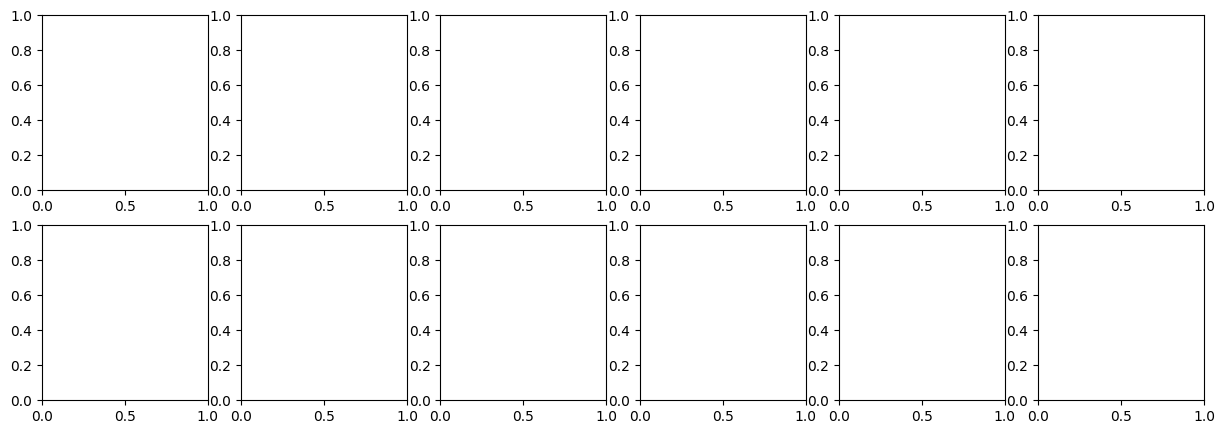

In [63]:
plot_predictions_and_heatmap(k_folds, all_us_img_paths, all_text_in, text_out, splits, Model_Path_Folds, device, class_index)